In [1]:
import pandas as pd
import pydicom as dicom
from PIL import Image
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_patient_dictionary(path_to_patient_folder):
    """
    
    Returns dict of different types of images in the folder of patient. 
    
    Returns:
        dict: key - type of images; value - list of DICOM files, which sorted in the ascending order with restepct to the
                    depth of the image slice.
    """
    patient_dict = {}
    
    dicom_file_names = os.listdir(path_to_patient_folder)
    
    for i in range(len(dicom_file_names)):
        cur_dicom_obj = dicom.dcmread(os.path.join(path_to_patient_folder, dicom_file_names[i]))
        
        if cur_dicom_obj.SeriesDescription not in patient_dict.keys():
            patient_dict[cur_dicom_obj.SeriesDescription] = []
        patient_dict[cur_dicom_obj.SeriesDescription].append(cur_dicom_obj)
        
    # sort each type of images with respect to their depth in ascending order
    for i in patient_dict:
        patient_dict[i].sort(key=lambda x: x.InstanceNumber)
    
    return patient_dict

def get_pixels_hu(list_of_imgs):
    """
    Convert stack of the images into Houndsfeld units
    """
    image = np.stack([s.pixel_array for s in list_of_imgs])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = list_of_imgs[0].RescaleIntercept
    slope = list_of_imgs[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def show_stack(list_of_imgs, rows=6, cols=6, start_with=10, show_every=3):
    """
    Show stack of the images with the given parameters.
    """
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(list_of_imgs[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()





### Read One Patient

In [3]:
dataset_path = '/home/marichka/Documents/CardioVision/ONLY_MPR'
reports_path = '/home/marichka/PycharmProjects/CoronaryArteryPlaqueIdentification/reports'
all_patients = os.listdir(dataset_path)
len(all_patients)

743

In [4]:
path_to_the_patient = os.path.join(dataset_path, all_patients[0])
pat_dict = get_patient_dictionary(path_to_the_patient)

In [5]:
pat_dict.keys()

dict_keys(['PDA2 *', 'PDA *', 'PLB *', 'LAD *', 'LCX *', 'LAD-D1 *'])

### Get unique values of all possible branches

In [9]:
all_keys = []

for p in tqdm(all_patients):
    path_to_the_patient = os.path.join(dataset_path, p)
    pat_dict = get_patient_dictionary(path_to_the_patient)
    for el in pat_dict.keys():
        all_keys.append(el)

100%|██████████| 743/743 [1:04:19<00:00,  4.87s/it]


In [10]:
# with open('list_unique_branches.txt', 'w') as f:
#     for item in all_keys:
#         f.write("%s\n" % item)

In [19]:
all_branches_df = pd.DataFrame(all_keys)
all_branches_df[0] = all_branches_df[0].apply(lambda x: x.split(' ')[0].split('*')[0])

In [24]:
num_unique = all_branches_df[0].value_counts()

pandas.core.series.Series

In [32]:
num_unique.index

Index(['LAD', 'LAD-D1', 'LCX', 'PDA', 'LCX-OM', 'PLB', 'LAD-D2', 'LCX-OM2',
       'RIB', 'OM', 'PDA2', 'LAD-D3', 'RCA', 'PLB2', 'LCX-OM3', 'RCA-PDA',
       'AM', 'OM2', 'RCA-PLB', 'RCA-AM', 'LCX-OM1', 'PLB1', 'OM3', 'LCX-PLB',
       'RCA-PDA2', 'LCX-PDA', 'PDA1', 'RCA-PLB2', 'LCX-OM4', 'RCA-PLB1', 'OM1',
       'LOCALISER', 'CT', 'OM-Branch', 'LCX-Branch', 'PDA3', 'LAD-D4', 'AM2',
       'AM1', 'RIB2', 'LCX-PLB2', 'RCA-PDA1', 'Conus', 'LAD-Branch', 'AXIAL',
       'LCX-PDA2', 'OM4', 'RCA-AM1', 'PLB3', 'LIMA-LAD', 'RIB1', 'RCA-AM2',
       'Branch', 'Aorta-D1', 'Aorta-PDA', 'Aorta-LCX', 'ECG', 'RIB-Branch',
       'Aorta-OM', 'D1', 'ScreenSave', 'Lt', 'RT', '78SSF', 'PatientReport',
       'Localiser', '2LAD-D2', 'SScoreSerSav', 'Dose', 'LCX2', 'LB',
       'Aorta-LAD', 'Aorta-D2', '81SSF', 'PDLB', 'LCX-PLB1', 'PDA-AM'],
      dtype='object')

In [27]:
# num_unique.to_csv('num_unique_branches.csv')

/home/marichka/anaconda3/envs/cardio_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### Example of getting the image

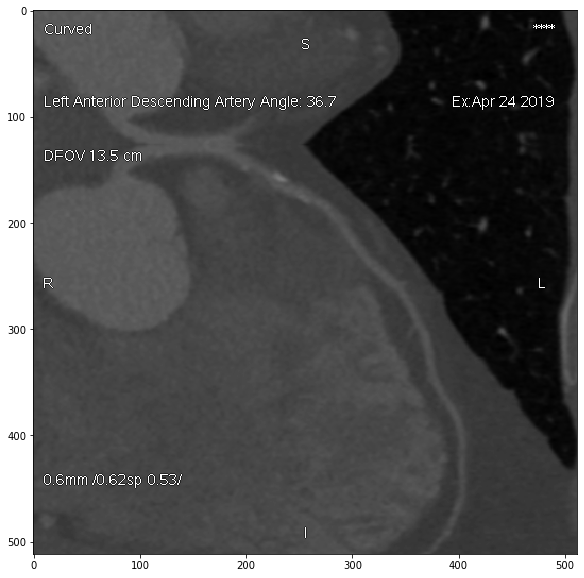

In [7]:
dicom_file = pat_dict['LAD *'][10]   # we take DICOM file of the 10th slice in calcium score section
img = dicom_file.pixel_array

plt.figure(figsize=(10,10))
plt.imshow(img, 'gray')